<a href="https://colab.research.google.com/github/porameht/bi_lstm_crf_ner/blob/main/NER_BI_LSTM_CRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pythainlp nltk tqdm dill scikit-learn gensim h5py numpy tensorflow
!pip install tensorflow==2.13.0 tensorflow-addons==0.21.0
# !pip install --upgrade tensorflow==2.17.0 tensorflow-addons==0.23.0 typeguard>=4.0.1 inflect==7.3.1

In [ ]:
import pickle

import json

import numpy as np
import dill
import re
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer
from itertools import chain
from sklearn.metrics import classification_report

In [ ]:
with open('/content/drive/MyDrive/address-ner-trainer/dataset/ner.data', 'rb') as file:
    datatofile = dill.load(file)

with open('/content/drive/MyDrive/address-ner-trainer/dataset/ner.data', 'rb') as file:
    nertofile = dill.load(file)


tagged_sents = []
prefixs = ['นาย', 'นาง', 'น.ส.', 'นางสาว', 'น.พ.', 'นพ.', 'พ.ต.ท.']

def replace_prefix(text):
    for i in prefixs:
        text = text.replace(i, '')
    return text

for i in datatofile:
    is_contain_prefix = False
    text_inside = []
    if(len(i) <= 1):
        continue
    for idx, j in enumerate(i):
        tag = j[2]
        if('ไม่ยืนยัน' in j[1]):
            tag = 'O'
        if(any([prefix in j[0] for prefix in prefixs])):
            is_contain_prefix = True
        ## Add S and E tag
#         if('B-' in tag):
#             if(idx == len(i)-1 or 'I-' not in i[idx+1][1]):
#                 tag = tag.replace('B-', 'S-')
#         if('I-' in tag):
#             if(idx == len(i)-1 or 'I-' not in i[idx+1][1]):
#                 tag = tag.replace('I-', 'E-')

        text_inside.append((j[0],tag))
    tagged_sents.append(text_inside)


    if(is_contain_prefix):
        dup_text_inside = []
        for word, tag in text_inside:
            word = replace_prefix(word)
            if(word == ''):
                continue
            else:
                dup_text_inside.append((word, tag))
        tagged_sents.append(dup_text_inside)

train_sents, test_sents= train_test_split(tagged_sents, test_size=0.1, random_state=112)

<ipython-input-42-1f82cb2e9ea2>:48: UserWarning: Glyph 3652 (\N{THAI CHARACTER SARA AI MAIMALAI}) missing from current font.
  plt.tight_layout()
<ipython-input-42-1f82cb2e9ea2>:48: UserWarning: Glyph 3617 (\N{THAI CHARACTER MO MA}) missing from current font.
  plt.tight_layout()
<ipython-input-42-1f82cb2e9ea2>:48: UserWarning: Glyph 3656 (\N{THAI CHARACTER MAI EK}) missing from current font.
  plt.tight_layout()
<ipython-input-42-1f82cb2e9ea2>:48: UserWarning: Glyph 3618 (\N{THAI CHARACTER YO YAK}) missing from current font.
  plt.tight_layout()
<ipython-input-42-1f82cb2e9ea2>:48: UserWarning: Glyph 3639 (\N{THAI CHARACTER SARA UEE}) missing from current font.
  plt.tight_layout()
<ipython-input-42-1f82cb2e9ea2>:48: UserWarning: Glyph 3609 (\N{THAI CHARACTER NO NU}) missing from current font.
  plt.tight_layout()
<ipython-input-42-1f82cb2e9ea2>:48: UserWarning: Glyph 3633 (\N{THAI CHARACTER MAI HAN-AKAT}) missing from current font.
  plt.tight_layout()


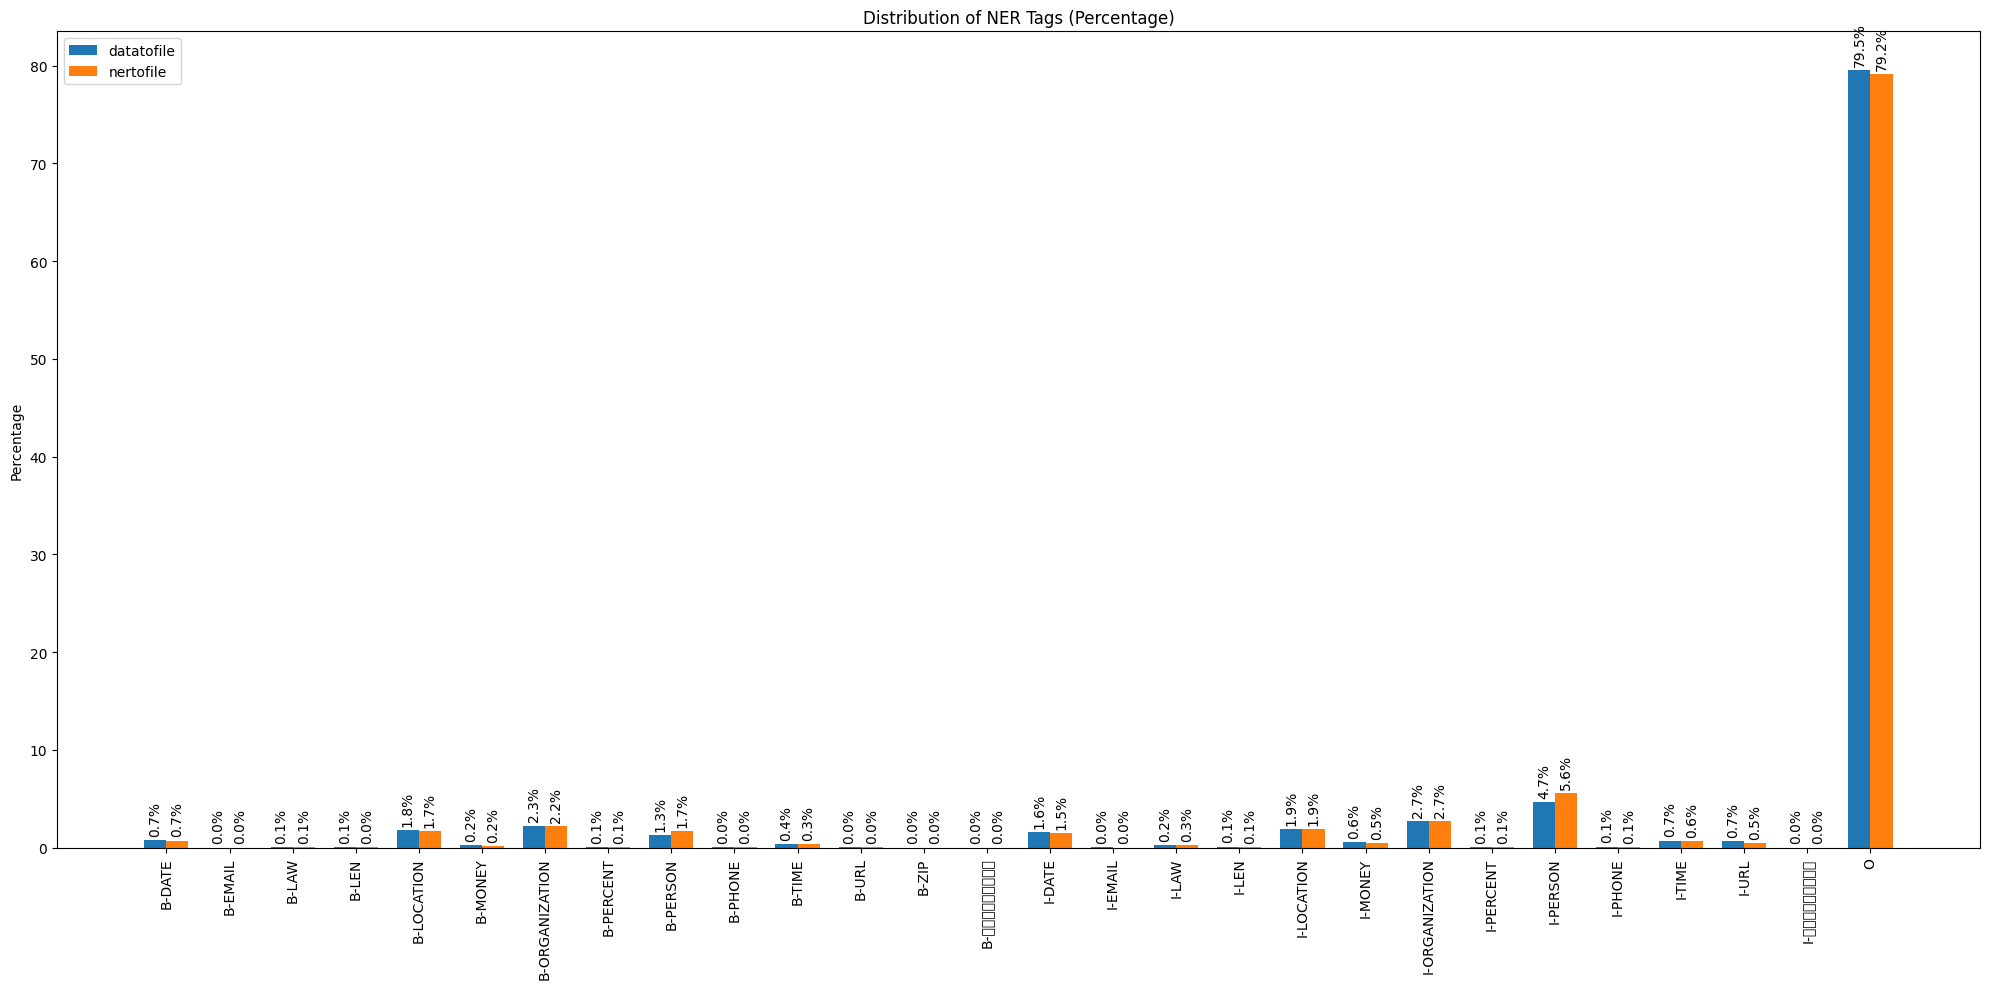

Top 10 most common tags in datatofile:
O: 196613 (79.53%)
I-PERSON: 11539 (4.67%)
I-ORGANIZATION: 6765 (2.74%)
B-ORGANIZATION: 5577 (2.26%)
I-LOCATION: 4752 (1.92%)
B-LOCATION: 4492 (1.82%)
I-DATE: 3853 (1.56%)
B-PERSON: 3159 (1.28%)
B-DATE: 1825 (0.74%)
I-TIME: 1790 (0.72%)

Top 10 most common tags in nertofile:
O: 305906 (79.17%)
I-PERSON: 21678 (5.61%)
I-ORGANIZATION: 10395 (2.69%)
B-ORGANIZATION: 8540 (2.21%)
I-LOCATION: 7194 (1.86%)
B-LOCATION: 6555 (1.70%)
B-PERSON: 6486 (1.68%)
I-DATE: 5667 (1.47%)
B-DATE: 2797 (0.72%)
I-TIME: 2509 (0.65%)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def count_ner_tags(data):
    all_tags = [tag for sentence in data for _, _, tag in sentence]
    return Counter(all_tags)

def plot_ner_distribution(datatofile, nertofile):
    datatofile_counts = count_ner_tags(datatofile)
    nertofile_counts = count_ner_tags(nertofile)

    all_tags = sorted(set(list(datatofile_counts.keys()) + list(nertofile_counts.keys())))

    # Calculate percentages
    total_datatofile = sum(datatofile_counts.values())
    total_nertofile = sum(nertofile_counts.values())

    datatofile_percentages = [datatofile_counts.get(tag, 0) / total_datatofile * 100 for tag in all_tags]
    nertofile_percentages = [nertofile_counts.get(tag, 0) / total_nertofile * 100 for tag in all_tags]

    x = np.arange(len(all_tags))
    width = 0.35

    fig, ax = plt.subplots(figsize=(20, 10))
    rects1 = ax.bar(x - width/2, datatofile_percentages, width, label='datatofile')
    rects2 = ax.bar(x + width/2, nertofile_percentages, width, label='nertofile')

    ax.set_ylabel('Percentage')
    ax.set_title('Distribution of NER Tags (Percentage)')
    ax.set_xticks(x)
    ax.set_xticklabels(all_tags, rotation=90)
    ax.legend()

    # Add value labels on top of each bar
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.1f}%',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', rotation=90)

    autolabel(rects1)
    autolabel(rects2)

    plt.tight_layout()
    plt.show()

    # Print top 10 most common tags for each dataset
    print("Top 10 most common tags in datatofile:")
    for tag, count in datatofile_counts.most_common(10):
        print(f"{tag}: {count} ({count/total_datatofile*100:.2f}%)")

    print("\nTop 10 most common tags in nertofile:")
    for tag, count in nertofile_counts.most_common(10):
        print(f"{tag}: {count} ({count/total_nertofile*100:.2f}%)")

# Assuming datatofile and nertofile are already loaded
plot_ner_distribution(datatofile, nertofile)

<ipython-input-3-cfce97055756>:69: UserWarning: Glyph 3652 (\N{THAI CHARACTER SARA AI MAIMALAI}) missing from current font.
  plt.tight_layout()
<ipython-input-3-cfce97055756>:69: UserWarning: Glyph 3617 (\N{THAI CHARACTER MO MA}) missing from current font.
  plt.tight_layout()
<ipython-input-3-cfce97055756>:69: UserWarning: Glyph 3656 (\N{THAI CHARACTER MAI EK}) missing from current font.
  plt.tight_layout()
<ipython-input-3-cfce97055756>:69: UserWarning: Glyph 3618 (\N{THAI CHARACTER YO YAK}) missing from current font.
  plt.tight_layout()
<ipython-input-3-cfce97055756>:69: UserWarning: Glyph 3639 (\N{THAI CHARACTER SARA UEE}) missing from current font.
  plt.tight_layout()
<ipython-input-3-cfce97055756>:69: UserWarning: Glyph 3609 (\N{THAI CHARACTER NO NU}) missing from current font.
  plt.tight_layout()
<ipython-input-3-cfce97055756>:69: UserWarning: Glyph 3633 (\N{THAI CHARACTER MAI HAN-AKAT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages

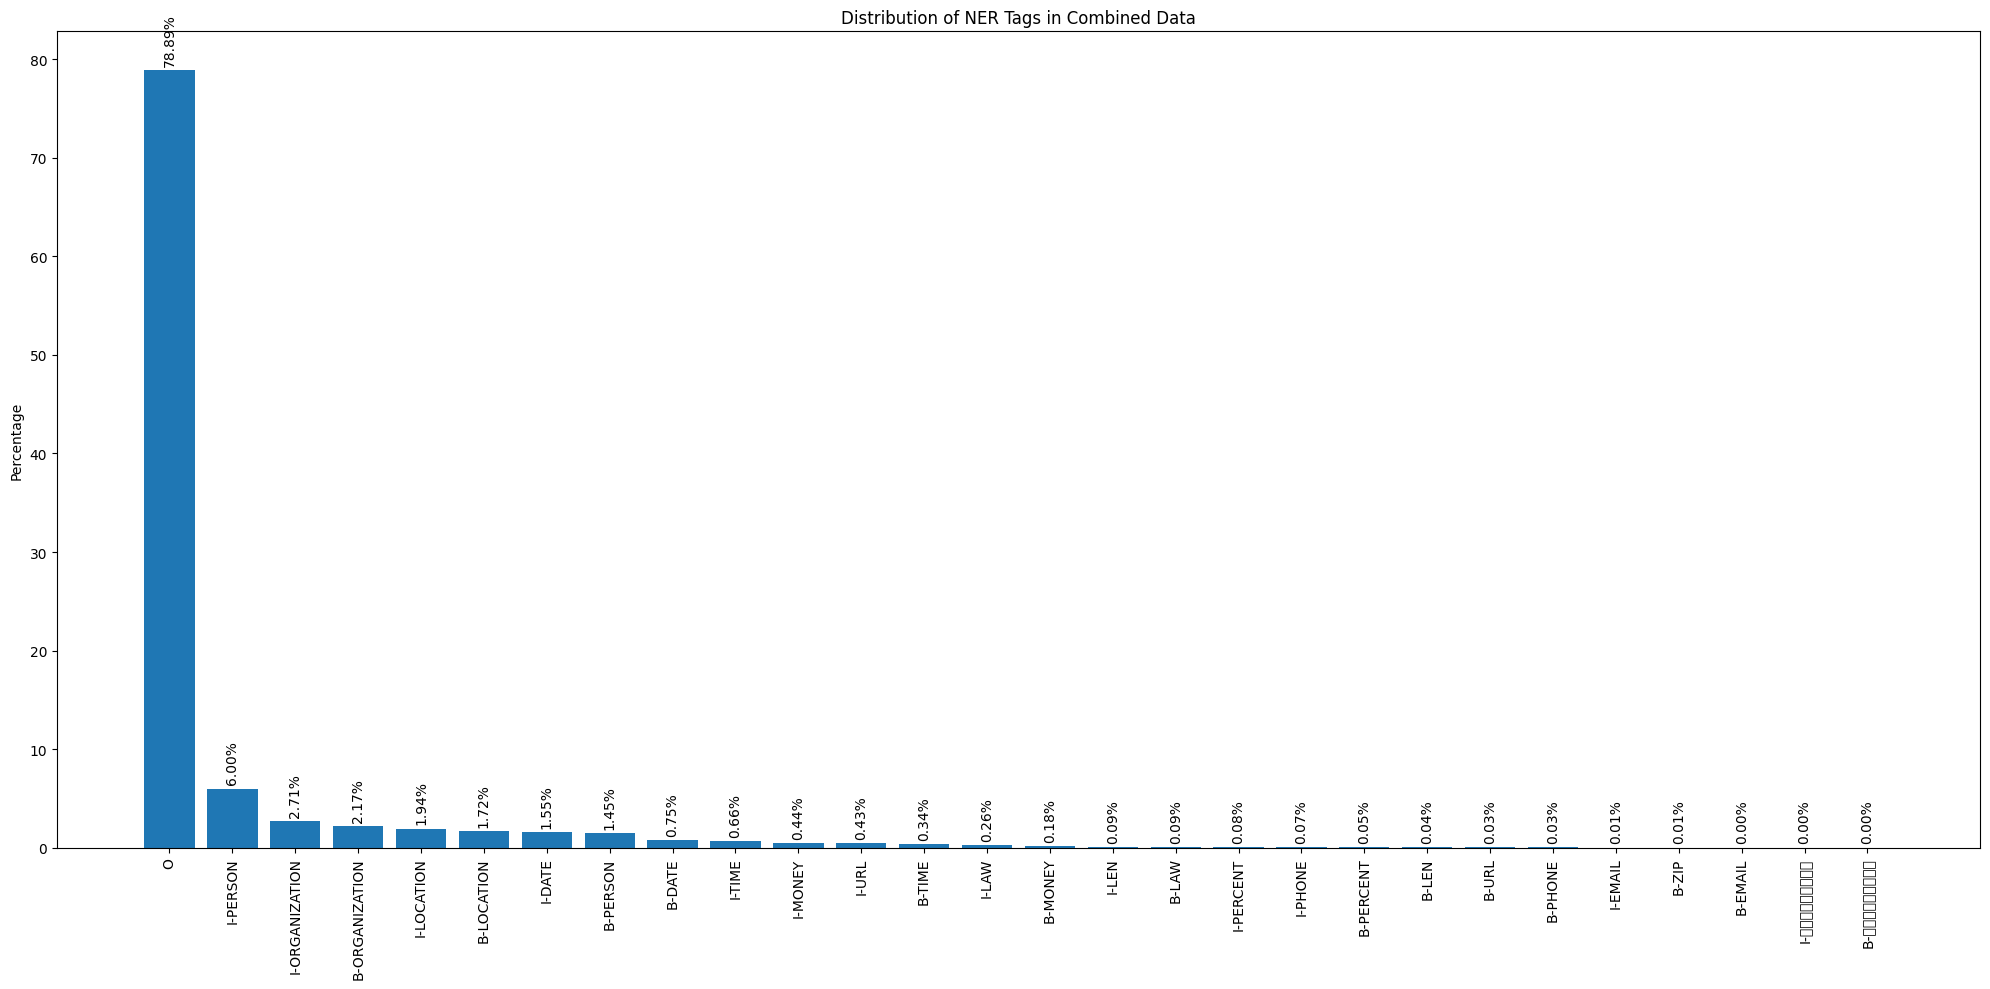

Summary of NER Tag Distribution:
Tag            Count     Percentage
-----------------------------------
O              676227    78.89%
I-PERSON       51431     6.00%
I-ORGANIZATION 23223     2.71%
B-ORGANIZATION 18601     2.17%
I-LOCATION     16645     1.94%
B-LOCATION     14708     1.72%
I-DATE         13271     1.55%
B-PERSON       12467     1.45%
B-DATE         6446      0.75%
I-TIME         5649      0.66%
I-MONEY        3810      0.44%
I-URL          3670      0.43%
B-TIME         2901      0.34%
I-LAW          2242      0.26%
B-MONEY        1546      0.18%
I-LEN          795       0.09%
B-LAW          744       0.09%
I-PERCENT      711       0.08%
I-PHONE        596       0.07%
B-PERCENT      452       0.05%
B-LEN          365       0.04%
B-URL          258       0.03%
B-PHONE        224       0.03%
I-EMAIL        122       0.01%
B-ZIP          52        0.01%
B-EMAIL        25        0.00%
I-ไม่ยืนยัน    4         0.00%
B-ไม่ยืนยัน    1         0.00%

Total number of sentences

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
import dill

def load_data(file_path):
    with open(file_path, 'rb') as file:
        return dill.load(file)

def replace_prefix(text, prefixs):
    for prefix in prefixs:
        text = text.replace(prefix, '')
    return text

def process_data(data, prefixs):
    tagged_sents = []
    for sentence in data:
        if len(sentence) <= 1:
            continue
        text_inside = []
        is_contain_prefix = False
        for idx, (word, pos, tag) in enumerate(sentence):
            if 'ไม่ยืนยัน' in pos:
                tag = 'O'
            if any(prefix in word for prefix in prefixs):
                is_contain_prefix = True
            text_inside.append((word, tag))

        tagged_sents.append(text_inside)

        if is_contain_prefix:
            dup_text_inside = [(replace_prefix(word, prefixs), tag) for word, tag in text_inside if replace_prefix(word, prefixs) != '']
            tagged_sents.append(dup_text_inside)

    return tagged_sents

def count_ner_tags(data):
    all_tags = [tag for sentence in data for _, tag in sentence]
    return Counter(all_tags)

def plot_ner_distribution(combined_data):
    tag_counts = count_ner_tags(combined_data)
    total_tags = sum(tag_counts.values())

    # Sort tags by frequency
    sorted_tags = sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)
    tags, counts = zip(*sorted_tags)

    percentages = [count / total_tags * 100 for count in counts]

    fig, ax = plt.subplots(figsize=(20, 10))
    bars = ax.bar(tags, percentages)

    ax.set_ylabel('Percentage')
    ax.set_title('Distribution of NER Tags in Combined Data')
    ax.set_xticks(range(len(tags)))
    ax.set_xticklabels(tags, rotation=90)

    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=90)

    plt.tight_layout()
    plt.show()

    # Print summary of tag distribution
    print("Summary of NER Tag Distribution:")
    print(f"{'Tag':<15}{'Count':<10}{'Percentage':<10}")
    print("-" * 35)
    for tag, count in sorted_tags:
        percentage = count / total_tags * 100
        print(f"{tag:<15}{count:<10}{percentage:.2f}%")

# Main execution
datatofile = load_data('/content/drive/MyDrive/address-ner-trainer/dataset/datatrain.data')
nertofile = load_data('/content/drive/MyDrive/address-ner-trainer/dataset/ner.data')

prefixs = ['นาย', 'นาง', 'น.ส.', 'นางสาว', 'น.พ.', 'นพ.', 'พ.ต.ท.']

processed_datatofile = process_data(datatofile, prefixs)
processed_nertofile = process_data(nertofile, prefixs)

combined_data = processed_datatofile + processed_nertofile

train_sents, test_sents = train_test_split(combined_data, test_size=0.1, random_state=112)

plot_ner_distribution(combined_data)

print(f"\nTotal number of sentences: {len(combined_data)}")
print(f"Number of training sentences: {len(train_sents)}")
print(f"Number of test sentences: {len(test_sents)}")

In [ ]:
thai2fit_model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/address-ner-trainer/thai2fit/thai2vecNoSym.bin',binary=True)
thai2fit_weight = thai2fit_model.vectors

In [ ]:
thai2fit_weight

array([[ 0.5691334 , -0.3733283 , -1.3620111 , ..., -0.11167767,
         0.00160926,  0.1423377 ],
       [ 0.8621748 ,  0.6304329 , -0.9730983 , ..., -0.2804809 ,
        -0.06645714, -0.03262454],
       [-0.01695964,  0.14895475, -1.0105608 , ..., -0.34607837,
        -0.06187863,  0.15685362],
       ...,
       [ 0.6418853 ,  0.21489567, -0.13987012, ..., -0.13923308,
         0.1846008 ,  0.40389898],
       [ 0.53645283,  0.20945884, -0.12532134, ..., -0.19032255,
         0.42437807,  0.37765843],
       [ 0.6157714 , -0.01145995, -0.16874076, ..., -0.18503019,
         0.3679345 ,  0.35344028]], dtype=float32)

In [ ]:
word_list = []
ner_list = []
thai2dict = {}

for sent in train_sents:
    for word in sent:
        word_list.append(word[0])
        ner_list.append(word[1])

# Updated this line to use index_to_key instead of index2word
for word in thai2fit_model.index_to_key:
    thai2dict[word] = thai2fit_model[word]

word_list.append("pad")
word_list.append("unknown")  # Special Token for Unknown words ("UNK")
ner_list.append("pad")

all_words = sorted(set(word_list))
all_ner = sorted(set(ner_list))
all_thai2dict = sorted(set(thai2dict))

word_to_ix = dict((c, i) for i, c in enumerate(all_words))  # convert word to index
ner_to_ix = dict((c, i) for i, c in enumerate(all_ner))  # convert ner to index
thai2dict_to_ix = dict((c, i) for i, c in enumerate(thai2dict))  # convert thai2fit to index

ix_to_word = dict((v,k) for k,v in word_to_ix.items())  # convert index to word
ix_to_ner = dict((v,k) for k,v in ner_to_ix.items())  # convert index to ner
ix_to_thai2dict = dict((v,k) for k,v in thai2dict_to_ix.items())  # convert index to thai2fit

n_word = len(word_to_ix)
n_tag = len(ner_to_ix)
n_thai2dict = len(thai2dict_to_ix)

print(f"Number of words: {n_word}")
print(f"Number of NER tags: {n_tag}")
print(f"Number of Thai2Dict entries: {n_thai2dict}")

Number of words: 16972
Number of NER tags: 29
Number of Thai2Dict entries: 55677


In [ ]:
chars = set([w_i for w in thai2dict for w_i in w])
char2idx = {c: i + 5 for i, c in enumerate(chars)}

char2idx["pad"] = 0
char2idx["unknown"] = 1
char2idx[" "] = 2

char2idx["$"] = 3
char2idx["#"] = 4
char2idx["!"] = 5
char2idx["%"] = 6
char2idx["&"] = 7
char2idx["*"] = 8
char2idx["+"] = 9
char2idx[","] = 10
char2idx["-"] = 11
char2idx["."] = 12
char2idx["/"] = 13
char2idx[":"] = 14
char2idx[";"] = 15
char2idx["?"] = 16
char2idx["@"] = 17
char2idx["^"] = 18
char2idx["_"] = 19
char2idx["`"] = 20
char2idx["="] = 21
char2idx["|"] = 22
char2idx["~"] = 23
char2idx["'"] = 24
char2idx['"'] = 25

char2idx["("] = 26
char2idx[")"] = 27
char2idx["{"] = 28
char2idx["}"] = 29
char2idx["<"] = 30
char2idx[">"] = 31
char2idx["["] = 32
char2idx["]"] = 33
char2idx["\n"] = 34

n_chars = len(char2idx)

In [ ]:
# with open('/content/drive/MyDrive/address-ner-trainer/save_data_trained/chardict.json', 'w') as chardict:
#     json.dump(char2idx, chardict)
# with open('/content/drive/MyDrive/address-ner-trainer/save_data_trained/nerdict.json', 'w') as nerdict:
#     json.dump(ner_to_ix, nerdict)
# with open('/content/drive/MyDrive/address-ner-trainer/save_data_trained/thai2dict_to_ix.json', 'w') as f:
#     json.dump(thai2dict_to_ix, f)

In [ ]:
# max_len = 284
# max_len_char = 30

# character_LSTM_unit = 32
# char_embedding_dim = 32
# main_lstm_unit = 256 ## Bidirectional 256 + 256 = 512
# lstm_recurrent_dropout = 0.5

# train_batch_size = 32
# train_epochs = 150

# กำหนดค่าพารามิเตอร์
max_len = 120 #284
max_len_char = 30
character_LSTM_unit = 32
char_embedding_dim = 32
main_lstm_unit = 256  # Bidirectional 256 + 256 = 512
lstm_recurrent_dropout = 0.5
n_tag = 29  # จำนวน tag ที่ใช้ (ปรับตามจำนวนจริงในโมเดลของคุณ)


In [ ]:
def prepare_sequence_word(input_text):
    idxs = list()
    for word in input_text:
        if word in thai2dict:
            idxs.append(thai2dict_to_ix[word])
        else:
            idxs.append(thai2dict_to_ix["unknown"]) #Use UNK tag for unknown word
    return idxs

def prepare_sequence_target(input_label):
    idxs = [ner_to_ix[w] for w in input_label]
    return idxs

In [ ]:
input_sent =[ [ word[0] for word in sent]for sent in train_sents ] #words only
train_targets =[ [ word[1] for word in sent]for sent in train_sents ] #NER only

input_test_sent =[ [ word[0] for word in sent]for sent in test_sents ] #words only
test_targets =[ [ word[1] for word in sent]for sent in test_sents ] #NER only

In [ ]:
# Copyright 2019 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Implementing Conditional Random Field loss."""

from __future__ import absolute_import, division, print_function

import tensorflow as tf

# Copyright 2019 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#
# Orginal implementation from keras_contrib/layers/crf
# ==============================================================================
"""Implementing Conditional Random Field layer."""

from __future__ import absolute_import, division, print_function

import tensorflow as tf
from typeguard import typechecked

from tensorflow_addons.text.crf import crf_decode, crf_log_likelihood
from tensorflow_addons.utils import types

@tf.keras.utils.register_keras_serializable(package="Addons")
class CRF(tf.keras.layers.Layer):
    """Linear chain conditional random field (CRF).
    Examples:
    ```python
        from tensorflow_addons.layers import CRF
        from tensorflow_addons.losses import crf_loss
        model = Sequential()
        model.add(Embedding(3001, 300, mask_zero=True)
        crf = CRF(10)
        model.add(crf)
        model.compile('adam', loss=crf_loss)
        model.fit(x, y)
    ```
    Arguments:
        units: Positive integer, dimensionality of the output space,
            should equal to tag num.
        chain_initializer: Initializer for the `chain_kernel` weights matrix,
            used for the CRF chain energy.
            (see [initializers](../initializers.md)).
        chain_regularizer: Regularizer function applied to
            the `chain_kernel` weights matrix.
        chain_constraint: Constraint function applied to
            the `chain_kernel` weights matrix.
        use_boundary: Boolean (default True), indicating if trainable
            start-end chain energies should be added to model.
        boundary_initializer: Initializer for the `left_boundary`,
            'right_boundary' weights vectors,
            used for the start/left and end/right boundary energy.
        boundary_regularizer: Regularizer function applied to
            the 'left_boundary', 'right_boundary' weight vectors.
        boundary_constraint: Constraint function applied to
            the `left_boundary`, `right_boundary` weights vectors.
        use_kernel: Boolean (default True), indicating if apply
            a fully connected layer before CRF op.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs.
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix.
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix.
        use_bias: Boolean (default True), whether the layer uses a bias vector.
        bias_initializer: Initializer for the bias vector.
        bias_regularizer: Regularizer function applied to the bias vector.
        bias_constraint: Constraint function applied to the bias vector.
        activation: default value is 'linear', Activation function to use.
    Input shape:
        3D tensor with shape: `(batch_size, sequence_length, feature_size)`.
    Output shape:
        2D tensor (dtype: int32) with shape: `(batch_size, sequence_length)`.
    Masking:
        This layer supports masking
        (2D tensor, shape: `(batch_size, sequence_length)`)
        for input data with a variable number of timesteps.
        This layer output same make tensor,
        NOTICE this may cause issue when you
        use some keras loss and metrics function which usually expect 1D mask.
    Loss function:
        Due to the TF 2.0 version support eager execution be default,
        there is no way can implement CRF loss as independent loss function.
        Thus, user should use loss method of this layer.
        See Examples (above) for detailed usage.
    References:
        - [Conditional Random Field](https://en.wikipedia.org/wiki/Conditional_random_field)
    """

    def __init__(
        self,
        units: int,
        chain_initializer: types.Initializer = "orthogonal",
        chain_regularizer: types.Regularizer = None,
        chain_constraint: types.Constraint = None,
        use_boundary: bool = True,
        boundary_initializer: types.Initializer = "zeros",
        boundary_regularizer: types.Regularizer = None,
        boundary_constraint: types.Constraint = None,
        use_kernel: bool = True,
        kernel_initializer: types.Initializer = "glorot_uniform",
        kernel_regularizer: types.Regularizer = None,
        kernel_constraint: types.Constraint = None,
        use_bias: bool = True,
        bias_initializer: types.Initializer = "zeros",
        bias_regularizer: types.Regularizer = None,
        bias_constraint: types.Constraint = None,
        activation: types.Activation = "linear",
        **kwargs
    ):
        super(CRF, self).__init__(**kwargs)

        # setup mask supporting flag, used by base class (the Layer)
        # because base class's init method will set it to False unconditionally
        # So this assigned must be executed after call base class's init method
        self.supports_masking = True

        self.units = units  # numbers of tags

        self.use_boundary = use_boundary
        self.use_bias = use_bias
        self.use_kernel = use_kernel

        self.activation = tf.keras.activations.get(activation)

        self.kernel_initializer = tf.keras.initializers.get(kernel_initializer)
        self.chain_initializer = tf.keras.initializers.get(chain_initializer)
        self.boundary_initializer = tf.keras.initializers.get(boundary_initializer)
        self.bias_initializer = tf.keras.initializers.get(bias_initializer)

        self.kernel_regularizer = tf.keras.regularizers.get(kernel_regularizer)
        self.chain_regularizer = tf.keras.regularizers.get(chain_regularizer)
        self.boundary_regularizer = tf.keras.regularizers.get(boundary_regularizer)
        self.bias_regularizer = tf.keras.regularizers.get(bias_regularizer)

        self.kernel_constraint = tf.keras.constraints.get(kernel_constraint)
        self.chain_constraint = tf.keras.constraints.get(chain_constraint)
        self.boundary_constraint = tf.keras.constraints.get(boundary_constraint)
        self.bias_constraint = tf.keras.constraints.get(bias_constraint)

        # values will be assigned in method
        self.input_spec = None

        # value remembered for loss/metrics function
        self.potentials = None
        self.sequence_length = None
        self.mask = None

        # global variable
        self.chain_kernel = None
        self._dense_layer = None
        self.left_boundary = None
        self.right_boundary = None

    def build(self, input_shape):
        input_shape = tuple(tf.TensorShape(input_shape).as_list())

        # see API docs of InputSpec for more detail
        self.input_spec = [tf.keras.layers.InputSpec(shape=input_shape)]

        # weights that work as transfer probability of each tags
        self.chain_kernel = self.add_weight(
            shape=(self.units, self.units),
            name="chain_kernel",
            initializer=self.chain_initializer,
            regularizer=self.chain_regularizer,
            constraint=self.chain_constraint,
        )

        # weight of <START> to tag probability and tag to <END> probability
        if self.use_boundary:
            self.left_boundary = self.add_weight(
                shape=(self.units,),
                name="left_boundary",
                initializer=self.boundary_initializer,
                regularizer=self.boundary_regularizer,
                constraint=self.boundary_constraint,
            )
            self.right_boundary = self.add_weight(
                shape=(self.units,),
                name="right_boundary",
                initializer=self.boundary_initializer,
                regularizer=self.boundary_regularizer,
                constraint=self.boundary_constraint,
            )

        if self.use_kernel:
            self._dense_layer = tf.keras.layers.Dense(
                units=self.units,
                activation=self.activation,
                use_bias=self.use_bias,
                bias_initializer=self.bias_initializer,
                kernel_regularizer=self.kernel_regularizer,
                bias_regularizer=self.bias_regularizer,
                kernel_constraint=self.kernel_constraint,
                bias_constraint=self.bias_constraint,
                dtype=self.dtype,
            )
        else:
            self._dense_layer = lambda x: tf.cast(x, dtype=self.dtype)

        super(CRF, self).build(input_shape)

    def call(self, inputs, mask=None, **kwargs):
        # mask: Tensor(shape=(batch_size, sequence_length), dtype=bool) or None

        if mask is not None:
            if tf.keras.backend.ndim(mask) != 2:
                raise ValueError("Input mask to CRF must have dim 2 if not None")

        # left padding of mask is not supported, due the underline CRF function
        # detect it and report it to user
        first_mask = None
        if mask is not None:
            left_boundary_mask = self._compute_mask_left_boundary(mask)
            first_mask = left_boundary_mask[:, 0]

        # remember this value for later use
        self.mask = mask

        if first_mask is not None:
            no_left_padding = tf.math.reduce_all(first_mask)
            msg = "Currently, CRF layer do not support left padding"
            with tf.control_dependencies(
                [
                    tf.debugging.assert_equal(
                        no_left_padding, tf.constant(True), message=msg
                    )
                ]
            ):
                self.potentials = self._dense_layer(inputs)
        else:
            self.potentials = self._dense_layer(inputs)

        # appending boundary probability info
        if self.use_boundary:
            self.potentials = self.add_boundary_energy(
                self.potentials, mask, self.left_boundary, self.right_boundary
            )

        self.sequence_length = self._get_sequence_length(inputs, mask)

        decoded_sequence, _ = self.get_viterbi_decoding(
            self.potentials, self.sequence_length
        )

        return decoded_sequence

    def _get_sequence_length(self, input_, mask):
        """Currently underline CRF fucntion (provided by
        tensorflow_addons.text.crf) do not support bi-direction masking (left
        padding / right padding), it support right padding by tell it the
        sequence length.
        this function is compute the sequence length from input and
        mask.
        """
        if mask is not None:
            sequence_length = self.mask_to_sequence_length(mask)
        else:
            # make a mask tensor from input, then used to generate sequence_length
            input_energy_shape = tf.shape(input_)
            raw_input_shape = tf.slice(input_energy_shape, [0], [2])
            alt_mask = tf.ones(raw_input_shape)

            sequence_length = self.mask_to_sequence_length(alt_mask)

        return sequence_length

    def mask_to_sequence_length(self, mask):
        """compute sequence length from mask."""
        sequence_length = tf.cast(tf.reduce_sum(tf.cast(mask, tf.int16), 1), tf.int64)
        return sequence_length

    @staticmethod
    def _compute_mask_right_boundary(mask):
        """input mask: 0011100, output left_boundary: 0000100."""
        # shift mask to left by 1: 0011100 => 0111000
        offset = 1
        left_shifted_mask = tf.concat(
            [mask[:, offset:], tf.zeros_like(mask[:, :offset])], axis=1
        )

        # NOTE: below code is different from keras_contrib
        # Original code in keras_contrib:
        # end_mask = K.cast(
        #   K.greater(self.shift_left(mask), mask),
        #   K.floatx()
        # )
        # has a bug, confirmed
        # by the original keras_contrib maintainer
        # Luiz Felix (github: lzfelix),

        # 0011100 > 0111000 => 0000100
        right_boundary = tf.greater(mask, left_shifted_mask)

        return right_boundary

    @staticmethod
    def _compute_mask_left_boundary(mask):
        """input mask: 0011100, output left_boundary: 0010000."""
        # shift mask to right by 1: 0011100 => 0001110
        offset = 1
        right_shifted_mask = tf.concat(
            [tf.zeros_like(mask[:, :offset]), mask[:, :-offset]], axis=1
        )

        # 0011100 > 0001110 => 0010000
        left_boundary = tf.greater(
            tf.cast(mask, tf.int32), tf.cast(right_shifted_mask, tf.int32)
        )
        # left_boundary = tf.greater(mask, right_shifted_mask)

        return left_boundary

    def add_boundary_energy(self, potentials, mask, start, end):
        def expand_scalar_to_3d(x):
            # expand tensor from shape (x, ) to (1, 1, x)
            return tf.reshape(x, (1, 1, -1))

        start = expand_scalar_to_3d(start)
        end = expand_scalar_to_3d(end)
        if mask is None:
            potentials = tf.concat(
                [potentials[:, :1, :] + start, potentials[:, 1:, :]], axis=1
            )
            potentials = tf.concat(
                [potentials[:, :-1, :], potentials[:, -1:, :] + end], axis=1
            )
        else:
            mask = tf.keras.backend.expand_dims(tf.cast(mask, start.dtype), axis=-1)
            start_mask = tf.cast(self._compute_mask_left_boundary(mask), start.dtype)

            end_mask = tf.cast(self._compute_mask_right_boundary(mask), end.dtype)
            potentials = potentials + start_mask * start
            potentials = potentials + end_mask * end
        return potentials

    def get_viterbi_decoding(self, potentials, sequence_length):
        # decode_tags: A [batch_size, max_seq_len] matrix, with dtype `tf.int32`
        decode_tags, best_score = crf_decode(
            potentials, self.chain_kernel, sequence_length
        )

        return decode_tags, best_score

    def get_config(self):
        # used for loading model from disk
        config = {
            "units": self.units,
            "use_boundary": self.use_boundary,
            "use_bias": self.use_bias,
            "use_kernel": self.use_kernel,
            "kernel_initializer": tf.keras.initializers.serialize(
                self.kernel_initializer
            ),
            "chain_initializer": tf.keras.initializers.serialize(
                self.chain_initializer
            ),
            "boundary_initializer": tf.keras.initializers.serialize(
                self.boundary_initializer
            ),
            "bias_initializer": tf.keras.initializers.serialize(self.bias_initializer),
            "activation": tf.keras.activations.serialize(self.activation),
            "kernel_regularizer": tf.keras.regularizers.serialize(
                self.kernel_regularizer
            ),
            "chain_regularizer": tf.keras.regularizers.serialize(
                self.chain_regularizer
            ),
            "boundary_regularizer": tf.keras.regularizers.serialize(
                self.boundary_regularizer
            ),
            "bias_regularizer": tf.keras.regularizers.serialize(self.bias_regularizer),
            "kernel_constraint": tf.keras.constraints.serialize(self.kernel_constraint),
            "chain_constraint": tf.keras.constraints.serialize(self.chain_constraint),
            "boundary_constraint": tf.keras.constraints.serialize(
                self.boundary_constraint
            ),
            "bias_constraint": tf.keras.constraints.serialize(self.bias_constraint),
        }
        base_config = super(CRF, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        output_shape = input_shape[:2]
        return output_shape

    def compute_mask(self, input_, mask=None):
        """keep mask shape [batch_size, max_seq_len]"""
        return mask

    def get_negative_log_likelihood(self, y_true):
        y_true = tf.cast(y_true, tf.int32)
        self.sequence_length = tf.cast(self.sequence_length, tf.int32)

        log_likelihood, _ = crf_log_likelihood(
            self.potentials, y_true, self.sequence_length, self.chain_kernel
        )

        return -log_likelihood

    def get_loss(self, y_true, y_pred):
        # we don't use y_pred, but caller pass it anyway, ignore it
        return self.get_negative_log_likelihood(y_true)

    def get_accuracy(self, y_true, y_pred):
        judge = tf.cast(tf.equal(y_pred, y_true), tf.keras.backend.floatx())
        if self.mask is None:
            return tf.reduce_mean(judge)
        else:
            mask = tf.cast(self.mask, tf.keras.backend.floatx())
            return tf.reduce_sum(judge * mask) / tf.reduce_sum(mask)

    def __call__(self, inputs, *args, **kwargs):
        outputs = super(CRF, self).__call__(inputs, *args, **kwargs)

        # A hack that add _keras_history to EagerTensor, make it more like normal Tensor
        for tensor in tf.nest.flatten(outputs):
            if not hasattr(tensor, "_keras_history"):
                tensor._keras_history = (self, 0, 0)

        return outputs

    @property
    def _compute_dtype(self):
        # fixed output dtype from underline CRF functions
        return tf.int32


@tf.keras.utils.register_keras_serializable(package="Addons")
class ConditionalRandomFieldLoss(object):
    def __init__(self, name: str = "crf_loss"):
        self.name = name

    def get_config(self):
        return {"name": self.name}

    def __call__(self, y_true, y_pred, sample_weight=None):
        crf_layer = y_pred._keras_history[0]

        # check if last layer is CRF
        if not isinstance(crf_layer, CRF):
            raise ValueError(
                "Last layer must be CRF for use {}.".format(self.__class__.__name__)
            )

        loss_vector = crf_layer.get_loss(y_true, y_pred)

        return tf.keras.backend.mean(loss_vector)


crf_loss = ConditionalRandomFieldLoss()


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, Bidirectional, Input, TimeDistributed, Layer
from tensorflow.keras.layers import Dense, SpatialDropout1D, Embedding, concatenate, Dropout
from tensorflow.keras.activations import gelu
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K

In [ ]:
## Word Training
X_word_tr = [prepare_sequence_word(s) for s in input_sent]
X_word_tr = pad_sequences(
    maxlen=max_len, sequences=X_word_tr, value=thai2dict_to_ix["pad"], padding='post', truncating='post'
)

## Character Training
X_char_tr = []
for sentence in tqdm(train_sents):
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                if(sentence[i][0][j] in char2idx):
                    word_seq.append(char2idx.get(sentence[i][0][j]))
                else:
                    word_seq.append(char2idx.get("unknown"))
            except:
                word_seq.append(char2idx.get("pad"))
        sent_seq.append(word_seq)
    X_char_tr.append(np.array(sent_seq))

## Sequence Label Training
y_tr = [prepare_sequence_target(s) for s in train_targets]
y_tr = pad_sequences(maxlen=max_len, sequences=y_tr, value=ner_to_ix["pad"], padding='post', truncating='post')

100%|██████████| 15913/15913 [00:18<00:00, 847.25it/s]


In [ ]:
## Word Testing
X_word_te = [prepare_sequence_word(s) for s in input_test_sent]
X_word_te = pad_sequences(maxlen=max_len, sequences=X_word_te, value=thai2dict_to_ix["pad"], padding='post', truncating='post')

## Character Testing
X_char_te = []
for sentence in tqdm(test_sents):
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                if(sentence[i][0][j] in char2idx):
                    word_seq.append(char2idx.get(sentence[i][0][j]))
                else:
                    word_seq.append(char2idx.get("unknown"))
            except:
                word_seq.append(char2idx.get("pad"))
        sent_seq.append(word_seq)
    X_char_te.append(np.array(sent_seq))

## Sequence Label Testing
y_te = [prepare_sequence_target(s) for s in test_targets]
y_te = pad_sequences(maxlen=max_len, sequences=y_te, value=ner_to_ix["pad"], padding='post', truncating='post')

100%|██████████| 1769/1769 [00:02<00:00, 859.36it/s]


In [ ]:
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.7 MB/s eta 0:00:00


In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
from tensorflow.keras.layers import Input, Embedding, TimeDistributed, LSTM, Bidirectional, concatenate, SpatialDropout1D, Dense
from tensorflow.keras.models import Model

# Word Input
word_in = Input(shape=(max_len,), name='word_input_')

# Word Embedding Using Thai2Fit
word_embeddings = Embedding(input_dim=n_thai2dict,
                            output_dim=400,
                            weights=[thai2fit_weight],
                            input_length=max_len,
                            mask_zero=False,
                            name='word_embedding',
                            trainable=False)(word_in)

# Character Input
char_in = Input(shape=(max_len, max_len_char,), name='char_input')

# Character Embedding
emb_char = TimeDistributed(Embedding(input_dim=n_chars,
                                     output_dim=char_embedding_dim,
                                     input_length=max_len_char,
                                     mask_zero=False))(char_in)

# Character Sequence to Vector via BiLSTM
char_enc = TimeDistributed(Bidirectional(LSTM(units=character_LSTM_unit,
                                              return_sequences=False,
                                              recurrent_dropout=lstm_recurrent_dropout)))(emb_char)

# Concatenate All Embedding
all_word_embeddings = concatenate([word_embeddings, char_enc])
all_word_embeddings = SpatialDropout1D(0.3)(all_word_embeddings)

# Main Model Dense attention
main_lstm = Bidirectional(LSTM(units=main_lstm_unit,
                               return_sequences=True,
                               recurrent_dropout=lstm_recurrent_dropout))(all_word_embeddings)
main_lstm = TimeDistributed(Dense(50, activation="relu"))(main_lstm)

out = CRF(n_tag)(main_lstm)  # CRF layer

# Model
model = Model(inputs=[word_in, char_in], outputs=out)



model.compile(optimizer="adam", loss=crf_loss, metrics=[Accuracy()])


model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 120, 30)]            0         []                            
                                                                                                  
 word_input_ (InputLayer)    [(None, 120)]                0         []                            
                                                                                                  
 time_distributed (TimeDist  (None, 120, 30, 32)          12800     ['char_input[0][0]']          
 ributed)                                                                                         
                                                                                                  
 word_embedding (Embedding)  (None, 120, 400)             2227080   ['word_input_[0][0]']     

In [ ]:
# from huggingface_hub import notebook_login

# notebook_login()

In [ ]:
import wandb
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

wandb_project="thai-address-ner"

character_LSTM_unit = 32
char_embedding_dim = 32
main_lstm_unit = 256 ## Bidirectional 256 + 256 = 512
lstm_recurrent_dropout = 0.5
train_batch_size = 32
train_epochs = 150
epochs = 50
# config={
#     "architecture": "BiLSTM-CRF",
#     "dataset": "Thai Address NER",
#     "epochs": 1,  # Update this to match your actual number of epochs
#     "batch_size": train_batch_size,
#     "max_len": max_len,
#     "max_len_char": max_len_char,
#     "char_embedding_dim": char_embedding_dim,
#     "character_LSTM_unit": character_LSTM_unit,
#     "main_lstm_unit": main_lstm_unit,
#     "lstm_recurrent_dropout": lstm_recurrent_dropout
# }

train_args={
    # Model Architecture
    "architecture": "BiLSTM-CRF",
    "dataset": "Thai Address NER",

    # Training Parameters
    "batch_size": train_batch_size,
    "epochs": epochs,  # num_train_epochs
    "learning_rate": 3e-5,
    "max_steps": -1,
    "gradient_accumulation_steps": 1,

    # Model Hyperparameters
    "max_len": max_len,
    "max_len_char": max_len_char,
    "char_embedding_dim": char_embedding_dim,
    "character_LSTM_unit": character_LSTM_unit,
    "main_lstm_unit": main_lstm_unit,
    "lstm_recurrent_dropout": lstm_recurrent_dropout,

    # Evaluation
    "evaluate_during_training": True,
    "evaluate_during_training_steps": 10,
    "save_eval_checkpoints": False,
    "eval_batch_size": 16,

    # Logging and Tracking
    "logging_steps": 1,
    "report_to": "wandb",

    # Model Sharing
    "push_to_hub": True,
}


In [ ]:
# Initialize wandb
wandb.init(project=wandb_project,config=train_args)

class WandbCallback(Callback):
    def __init__(self, validation_data=None):
        super(WandbCallback, self).__init__()
        self.validation_data = validation_data
        self.best_accuracy = 0
        self.best_loss = float('inf')
        self.final_accuracy = 0
        self.final_loss = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current_accuracy = logs.get('val_accuracy', 0)
        current_loss = logs.get('val_loss', float('inf'))

        if current_accuracy > self.best_accuracy:
            self.best_accuracy = current_accuracy
        if current_loss < self.best_loss:
            self.best_loss = current_loss

        self.final_accuracy = current_accuracy
        self.final_loss = current_loss

        wandb.log({
            "accuracy": logs.get('accuracy'),
            "val_accuracy": self.final_accuracy,
            "loss": logs.get('loss'),
            "val_loss": self.final_loss,
            "best_val_accuracy": self.best_accuracy,
            "best_val_loss": self.best_loss
        })

    def on_train_end(self, logs=None):
        wandb.alert(
            title="🟢 BiLSTM-CRF Model + DATASET THAINER",
            text=f"Training has finished. 50 epochs\n"
                 f"Final Validation Accuracy: {self.final_accuracy:.4f}\n"
                 f"Final Validation Loss: {self.final_loss:.4f}\n"
                 f"Best Validation Accuracy: {self.best_accuracy:.4f}\n"
                 f"Best Validation Loss: {self.best_loss:.4f}",
            level=wandb.AlertLevel.INFO
        )
        print("Training completed. WandB alert sent.")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: porameht (leanbiz). Use `wandb login --relogin` to force relogin


In [ ]:
# Define callbacks
filepath = "/content/drive/MyDrive/address-ner-trainer/newdata/weights-improvement-thainer-{epoch:02d}-{accuracy:.3f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
wandb_callback = WandbCallback()

callbacks_list = [checkpoint, wandb_callback]


# # Reshape character input
X_char_tr_reshaped = np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))
X_char_te_reshaped = np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))

# # Train the model
history = model.fit(
    [X_word_tr, X_char_tr_reshaped],
    y_tr,
    batch_size=train_batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=(
        [X_word_te, X_char_te_reshaped],
        y_te
    ),
    shuffle=True
)

# End the wandb run
wandb.finish()

Epoch 1/50
498/498 [==============================] - ETA: 0s - loss: 22.7937 - accuracy: 0.9479
Epoch 1: val_accuracy improved from -inf to 0.97283, saving model to /content/drive/MyDrive/address-ner-trainer/newdata/weights-improvement-thainer-01-0.948.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


498/498 [==============================] - 388s 756ms/step - loss: 22.7937 - accuracy: 0.9479 - val_loss: 9.4671 - val_accuracy: 0.9728
Epoch 2/50
498/498 [==============================] - ETA: 0s - loss: 8.1067 - accuracy: 0.9759
Epoch 2: val_accuracy improved from 0.97283 to 0.98206, saving model to /content/drive/MyDrive/address-ner-trainer/newdata/weights-improvement-thainer-02-0.976.hdf5
498/498 [==============================] - 376s 755ms/step - loss: 8.1067 - accuracy: 0.9759 - val_loss: 5.7430 - val_accuracy: 0.9821
Epoch 3/50
498/498 [==============================] - ETA: 0s - loss: 5.3809 - accuracy: 0.9825
Epoch 3: val_accuracy improved from 0.98206 to 0.98594, saving model to /content/drive/MyDrive/address-ner-trainer/newdata/weights-improvement-thainer-03-0.983.hdf5
498/498 [==============================] - 364s 730ms/step - loss: 5.3809 - accuracy: 0.9825 - val_loss: 4.0459 - val_accuracy: 0.9859
Epoch 4/50
498/498 [==============================] - ETA: 0s - loss: 4.

In [ ]:
# save_filepath="saved_model/last_weight-50.hdf5"
# model.save_weights(save_filepath)

In [ ]:
load_filepath="/content/drive/MyDrive/address-ner-trainer/newdata/weights-improvement-thainer-25-0.998.hdf5"
model.load_weights(load_filepath)

In [ ]:
pred_model = model.predict([X_word_te,np.array(X_char_te).reshape((len(X_char_te),max_len, max_len_char))], verbose=1)

56/56 [==============================] - 11s 173ms/step


In [ ]:
# y_pred = []
# y_true = []

# for i in range(0,len(pred_model)):
#     try:
#         out = pred_model[i]
#         true = y_te[i]
#         revert_pred=[ix_to_ner[i] for i in out]
#         revert_true=[ix_to_ner[i] for i in true]
#         y_pred.append(revert_pred)
#         y_true.append(revert_true)
#     except:
#         print (i)

In [ ]:
# def ner_classification_report(y_true, y_pred):
#     lb = LabelBinarizer()
#     y_true_combined = lb.fit_transform(list(chain.from_iterable(y_true)))
#     y_pred_combined = lb.transform(list(chain.from_iterable(y_pred)))
#     tagset = list(sorted(set(lb.classes_)))
#     tagset = [i for i in tagset if len(i.split('-')) == 2]
#     class_indices = {cls: idx for idx, cls in enumerate(lb.classes_)}
#     print(list(sorted(set(lb.classes_))))
#     return classification_report(
#         y_true_combined,
#         y_pred_combined,
#         labels = [class_indices[cls] for cls in tagset],
#         target_names = tagset,
#         digits=4
#     )

In [ ]:
# y_pred = np.array(y_pred)
# y_true = np.array(y_true)

# print(ner_classification_report(y_true, y_pred))

['B-DATE', 'B-EMAIL', 'B-LAW', 'B-LEN', 'B-LOCATION', 'B-MONEY', 'B-ORGANIZATION', 'B-PERCENT', 'B-PERSON', 'B-PHONE', 'B-TIME', 'B-URL', 'B-ZIP', 'I-DATE', 'I-EMAIL', 'I-LAW', 'I-LEN', 'I-LOCATION', 'I-MONEY', 'I-ORGANIZATION', 'I-PERCENT', 'I-PERSON', 'I-PHONE', 'I-TIME', 'I-URL', 'O', 'pad']


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

        B-DATE     0.6561    0.6247    0.6400       397
       B-EMAIL     0.0000    0.0000    0.0000         1
         B-LAW     0.0000    0.0000    0.0000        36
         B-LEN     0.0000    0.0000    0.0000        12
    B-LOCATION     0.6170    0.3161    0.4180       851
       B-MONEY     0.0000    0.0000    0.0000        69
B-ORGANIZATION     0.7945    0.3139    0.4500      1096
     B-PERCENT     0.0000    0.0000    0.0000        20
      B-PERSON     0.7137    0.5711    0.6345       851
       B-PHONE     0.0000    0.0000    0.0000        21
        B-TIME     0.3529    0.0331    0.0606       181
         B-URL     0.0000    0.0000    0.0000        13
         B-ZIP     0.0000    0.0000    0.0000         1
        I-DATE     0.8876    0.7880    0.8349       802
       I-EMAIL     0.0000    0.0000    0.0000         2
         I-LAW     0.0000    0.0000    0.0000       139
         I-LEN     0.0000    0.0000    0.0000  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import wandb
import numpy as np
import pandas as pd
from itertools import chain
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, accuracy_score

if wandb.run is None:
    wandb.init(project="thai-address-ner", job_type="evaluation")

# pred_model = model.predict([X_word_te, np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))], verbose=1)

y_pred = []
y_true = []

for i in range(0, len(pred_model)):
    try:
        out = pred_model[i]
        true = y_te[i]
        revert_pred = [ix_to_ner[i] for i in out]
        revert_true = [ix_to_ner[i] for i in true]
        y_pred.append(revert_pred)
        y_true.append(revert_true)
    except:
        print(i)

def ner_classification_report(y_true, y_pred):
    lb = LabelBinarizer()
    y_true_combined = lb.fit_transform(list(chain.from_iterable(y_true)))
    y_pred_combined = lb.transform(list(chain.from_iterable(y_pred)))
    tagset = list(sorted(set(lb.classes_)))
    tagset = [i for i in tagset if len(i.split('-')) == 2]
    class_indices = {cls: idx for idx, cls in enumerate(lb.classes_)}
    print(list(sorted(set(lb.classes_))))
    report = classification_report(
        y_true_combined,
        y_pred_combined,
        labels = [class_indices[cls] for cls in tagset],
        target_names = tagset,
        digits=4,
        output_dict=True  # Return a dict instead of a string
    )
    return report, y_true_combined, y_pred_combined, tagset, class_indices

y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Get the classification report and combined true/pred values
report, y_true_combined, y_pred_combined, tagset, class_indices = ner_classification_report(y_true, y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_true_combined.argmax(axis=1), y_pred_combined.argmax(axis=1))

# Log the report to wandb
wandb.log({"classification_report": wandb.Table(dataframe=pd.DataFrame(report).transpose())})

# Log individual metrics
for label, metrics in report.items():
    if isinstance(metrics, dict):  # Skip non-dict items
        wandb.log({f"{label}_precision": metrics['precision'],
                   f"{label}_recall": metrics['recall'],
                   f"{label}_f1-score": metrics['f1-score'],
                   f"{label}_support": metrics['support']})

# Log overall metrics
wandb.log({"overall_accuracy": accuracy,
           "overall_macro_avg_f1": report['macro avg']['f1-score'],
           "overall_weighted_avg_f1": report['weighted avg']['f1-score']})

# Print the report and accuracy (optional)
print(classification_report(
    y_true_combined,
    y_pred_combined,
    labels = [class_indices[cls] for cls in tagset],
    target_names = tagset,
    digits=4
))
print(f"Overall Accuracy: {accuracy:.4f}")

# Create a notification with evaluation results
wandb.alert(
    title="Evaluation Completed: Thai Address NER",
    text=f"Evaluation has finished.\n"
         f"Overall Accuracy: {accuracy:.4f}\n"
         f"Macro Avg F1-Score: {report['macro avg']['f1-score']:.4f}\n"
         f"Weighted Avg F1-Score: {report['weighted avg']['f1-score']:.4f}\n\n"
         f"Individual Entity Performance:\n" +
         "\n".join([f"{label}: F1-Score: {metrics['f1-score']:.4f}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}"
                    for label, metrics in report.items() if isinstance(metrics, dict) and label not in ['micro avg', 'macro avg', 'weighted avg']]),
    level=wandb.AlertLevel.INFO
)

# Finish the wandb run
wandb.finish()

['B-DATE', 'B-EMAIL', 'B-LAW', 'B-LEN', 'B-LOCATION', 'B-MONEY', 'B-ORGANIZATION', 'B-PERCENT', 'B-PERSON', 'B-PHONE', 'B-TIME', 'B-URL', 'B-ZIP', 'I-DATE', 'I-EMAIL', 'I-LAW', 'I-LEN', 'I-LOCATION', 'I-MONEY', 'I-ORGANIZATION', 'I-PERCENT', 'I-PERSON', 'I-PHONE', 'I-TIME', 'I-URL', 'O', 'pad']


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

                precision    recall  f1-score   support

        B-DATE     0.9889    1.0000    0.9944       622
       B-EMAIL     1.0000    1.0000    1.0000         3
         B-LAW     1.0000    0.9753    0.9875        81
         B-LEN     1.0000    1.0000    1.0000        38
    B-LOCATION     0.9942    0.9899    0.9921      1388
       B-MONEY     1.0000    1.0000    1.0000       124
B-ORGANIZATION     0.9898    0.9898    0.9898      1865
     B-PERCENT     1.0000    1.0000    1.0000        32
      B-PERSON     0.9585    0.9513    0.9549      1336
       B-PHONE     1.0000    1.0000    1.0000        17
        B-TIME     0.9813    0.9962    0.9887       264
         B-URL     1.0000    1.0000    1.0000        25
         B-ZIP     1.0000    1.0000    1.0000         3
        I-DATE     0.9969    1.0000    0.9985      1292
       I-EMAIL     1.0000    1.0000    1.0000        16
         I-LAW     1.0000    0.9767    0.9882       257
         I-LEN     1.0000    1.0000    1.0000  

B-DATE_f1-score,▁
B-DATE_precision,▁
B-DATE_recall,▁
B-DATE_support,▁
B-EMAIL_f1-score,▁
B-EMAIL_precision,▁
B-EMAIL_recall,▁
B-EMAIL_support,▁
B-LAW_f1-score,▁
B-LAW_precision,▁
B-LAW_recall,▁


In [ ]:
from tensorflow.keras.models import load_model
from os.path import join as opj
model = load_model("/content/drive/MyDrive/address-ner-trainer/saved_model/ner.h5", custom_objects={"CRF": CRF}, compile=False)


In [ ]:
# pred_model1 = model.predict([X_word_te_padded, X_char_te_reshaped], verbose=1)
pred_model = model.predict([X_word_te,np.array(X_char_te).reshape((len(X_char_te),max_len, max_len_char))], verbose=1)

32/32 [==============================] - 7s 182ms/step


In [ ]:
import wandb
import numpy as np
import pandas as pd
from itertools import chain
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, accuracy_score

if wandb.run is None:
    wandb.init(project="thai-address-ner", job_type="evaluation")

# pred_model = model.predict([X_word_te, np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))], verbose=1)

y_pred = []
y_true = []

for i in range(0, len(pred_model)):
    try:
        out = pred_model[i]
        true = y_te[i]
        revert_pred = [ix_to_ner[i] for i in out]
        revert_true = [ix_to_ner[i] for i in true]
        y_pred.append(revert_pred)
        y_true.append(revert_true)
    except:
        print(i)

def ner_classification_report(y_true, y_pred):
    lb = LabelBinarizer()
    y_true_combined = lb.fit_transform(list(chain.from_iterable(y_true)))
    y_pred_combined = lb.transform(list(chain.from_iterable(y_pred)))
    tagset = list(sorted(set(lb.classes_)))
    tagset = [i for i in tagset if len(i.split('-')) == 2]
    class_indices = {cls: idx for idx, cls in enumerate(lb.classes_)}
    print(list(sorted(set(lb.classes_))))
    report = classification_report(
        y_true_combined,
        y_pred_combined,
        labels = [class_indices[cls] for cls in tagset],
        target_names = tagset,
        digits=4,
        output_dict=True  # Return a dict instead of a string
    )
    return report, y_true_combined, y_pred_combined, tagset, class_indices

y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Get the classification report and combined true/pred values
report, y_true_combined, y_pred_combined, tagset, class_indices = ner_classification_report(y_true, y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_true_combined.argmax(axis=1), y_pred_combined.argmax(axis=1))

# Log the report to wandb
wandb.log({"classification_report": wandb.Table(dataframe=pd.DataFrame(report).transpose())})

# Log individual metrics
for label, metrics in report.items():
    if isinstance(metrics, dict):  # Skip non-dict items
        wandb.log({f"{label}_precision": metrics['precision'],
                   f"{label}_recall": metrics['recall'],
                   f"{label}_f1-score": metrics['f1-score'],
                   f"{label}_support": metrics['support']})

# Log overall metrics
wandb.log({"overall_accuracy": accuracy,
           "overall_macro_avg_f1": report['macro avg']['f1-score'],
           "overall_weighted_avg_f1": report['weighted avg']['f1-score']})

# Print the report and accuracy (optional)
print(classification_report(
    y_true_combined,
    y_pred_combined,
    labels = [class_indices[cls] for cls in tagset],
    target_names = tagset,
    digits=4
))
print(f"Overall Accuracy: {accuracy:.4f}")

# Create a notification with evaluation results
wandb.alert(
    title="Evaluation Completed: Thai Address NER 🤔 (Old Model)",
    text=f"Evaluation has finished.\n"
         f"Overall Accuracy: {accuracy:.4f}\n"
         f"Macro Avg F1-Score: {report['macro avg']['f1-score']:.4f}\n"
         f"Weighted Avg F1-Score: {report['weighted avg']['f1-score']:.4f}\n\n"
         f"Individual Entity Performance:\n" +
         "\n".join([f"{label}: F1-Score: {metrics['f1-score']:.4f}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}"
                    for label, metrics in report.items() if isinstance(metrics, dict) and label not in ['micro avg', 'macro avg', 'weighted avg']]),
    level=wandb.AlertLevel.INFO
)

# Finish the wandb run
wandb.finish()

['B-DATE', 'B-EMAIL', 'B-LAW', 'B-LEN', 'B-LOCATION', 'B-MONEY', 'B-ORGANIZATION', 'B-PERCENT', 'B-PERSON', 'B-PHONE', 'B-TIME', 'B-URL', 'B-ZIP', 'I-DATE', 'I-EMAIL', 'I-LAW', 'I-LEN', 'I-LOCATION', 'I-MONEY', 'I-ORGANIZATION', 'I-PERCENT', 'I-PERSON', 'I-PHONE', 'I-TIME', 'I-URL', 'O', 'pad']


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

                precision    recall  f1-score   support

        B-DATE     0.9124    0.8368    0.8730       386
       B-EMAIL     0.0000    0.0000    0.0000         1
         B-LAW     0.8889    0.6667    0.7619        36
         B-LEN     0.8000    1.0000    0.8889        12
    B-LOCATION     0.9105    0.7398    0.8163       811
       B-MONEY     0.8222    0.5873    0.6852        63
B-ORGANIZATION     0.8735    0.6848    0.7677      1069
     B-PERCENT     0.8750    0.5833    0.7000        12
      B-PERSON     0.7786    0.6631    0.7162       843
       B-PHONE     1.0000    0.0952    0.1739        21
        B-TIME     0.6209    0.5337    0.5740       178
         B-URL     0.9091    0.9091    0.9091        11
         B-ZIP     0.0000    0.0000    0.0000         1
        I-DATE     0.0000    0.0000    0.0000       777
       I-EMAIL     0.0000    0.0000    0.0000         2
         I-LAW     0.0000    0.0000    0.0000       139
         I-LEN     0.0000    0.0000    0.0000  

B-DATE_f1-score,▁
B-DATE_precision,▁
B-DATE_recall,▁
B-DATE_support,▁
B-EMAIL_f1-score,▁
B-EMAIL_precision,▁
B-EMAIL_recall,▁
B-EMAIL_support,▁
B-LAW_f1-score,▁
B-LAW_precision,▁
B-LAW_recall,▁


In [ ]:
from tensorflow.keras.models import load_model

custom_objects = {'CRF': CRF}
model = load_model('/content/drive/MyDrive/address-ner-trainer/train_colab/weights-improvement-20-0.998.hdf5', custom_objects=custom_objects)

model.save('/content/drive/MyDrive/address-ner-trainer/train_colab/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
